<a href="https://colab.research.google.com/github/aishwaryabit1603/Ocr_Project/blob/main/ocr_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
pip install python-levenshtein

In [41]:
# pip install pytesseract
!sudo apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [141]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 16.4 MB/s eta 0:00:00


In [172]:
import cv2
import pytesseract
from spellchecker import SpellChecker
import re
import Levenshtein
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Accuracy: 90.70%


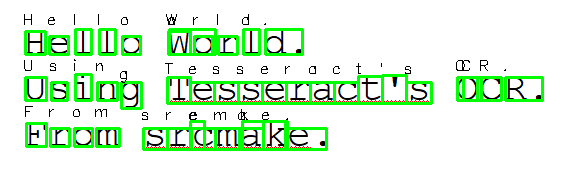

In [174]:
# Function to preprocess image
def preprocess_image(image_path):
    image = cv2.imread(image_path)

    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    binary_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    denoised_img = cv2.fastNlMeansDenoising(gray_img, None, h=10, templateWindowSize=7, searchWindowSize=21)

    return image, denoised_img

In [ ]:
# Function to detect characters, draw bounding boxes, and overlay recognized characters
def detect_and_overlay_characters(image, processed_image):
    h, w = processed_image.shape

    boxes = pytesseract.image_to_boxes(processed_image)

    spell = SpellChecker()

    for box in boxes.splitlines():
        box = box.split(' ')
        character = box[0]
        x, y, x2, y2 = int(box[1]), int(box[2]), int(box[3]), int(box[4])

        cv2.rectangle(image, (x, h - y), (x2, h - y2), (0, 255, 0), 2)

        text_width, text_height = cv2.getTextSize(character, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
        text_x = x - 3
        text_y = h - y - 30

        cv2.putText(image, character, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

        corrected_character = spell.correction(character)
        if corrected_character != character:
            cv2.putText(image, corrected_character, (text_x, text_y - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    return image

In [ ]:
# Function for post-processing recognized text
def post_process_text(text):
    processed_text = text.lower()

    processed_text = ' '.join(processed_text.split())

    spell = SpellChecker()
    corrected_words = []
    for word in processed_text.split():
        corrected_word = spell.correction(word)
        if corrected_word is not None:
            corrected_words.append(corrected_word)
        else:
            corrected_words.append(word)  # Use original word if no correction found

    corrected_text = ' '.join(corrected_words)

    return corrected_text

In [ ]:
# Function to calculate Levenshtein distance
def calculate_levenshtein_distance(pred_text, true_text):
    return Levenshtein.distance(pred_text.replace(' ', ''), true_text.replace(' ', ''))

In [ ]:
# Function to perform OCR on an image and measure accuracy
def perform_ocr_and_measure_accuracy(image_path, ground_truth):
    original_image, processed_image = preprocess_image(image_path)

    result_image = detect_and_overlay_characters(original_image.copy(), processed_image)

    text = pytesseract.image_to_string(processed_image)

    corrected_text = post_process_text(text)

    ground_truth_clean = re.sub(r'\s+', '', ground_truth.lower())

    ocr_output_clean = re.sub(r'\s+', '', corrected_text.lower())

    distance = calculate_levenshtein_distance(ocr_output_clean, ground_truth_clean)

    accuracy = 1 - (distance / max(len(ocr_output_clean), len(ground_truth_clean)))

    return result_image, corrected_text, accuracy

In [ ]:
if __name__ == '__main__':
    image_path = '/content/ocr_orig.jpg'
    ground_truth = """Hello World .
                    Using Tesseract's OCR.
                    From srcmake."""

    result_image, corrected_text, accuracy = perform_ocr_and_measure_accuracy(image_path, ground_truth)

    print(f"Accuracy: {accuracy:.2%}")

    # Display the result
    cv2_imshow(result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()